In [1]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
# Unzipping the data
!unzip -q "archive.zip"

--2021-11-10 18:29:54--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-11-10 18:29:54--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc00107ca278286d55928ed393d3.dl.dropboxusercontent.com/cd/0/inline/BZvQD9ocR09cGAyA_zBinnrKJ1_SVvENOeWsm5X-xekW-3t0VOC2M2R7YJLgSbg97WE1Co0uuFrAbRzlghElMCUZSfaQxl9JvYVf8w_A6_1lE7j9bC6KM2lwY6cCt7zFEe1Uk0UU-S0nPrcbUv4Ht0u-/file# [following]
--2021-11-10 18:29:54--  https://uc00107ca278286d55928ed393d3.dl.dropboxusercontent.com/cd/0/inline/BZvQD9ocR09cGAyA_zBinnrKJ1_SVvENOeWsm5X-xekW-3t0VOC2M2R7YJLgSbg97WE1Co0uuFrAbRzlghElMCUZSfaQx

In [24]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [58]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [59]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7fa446c61ed0>


In [60]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/PNEUMONIA/person734_virus_1355.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1940_bacteria_4861.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1270_virus_2163.jpeg')]


In [61]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[:3])

['chest_xray/train/PNEUMONIA/person734_virus_1355.jpeg', 'chest_xray/train/PNEUMONIA/person1940_bacteria_4861.jpeg', 'chest_xray/train/PNEUMONIA/person1270_virus_2163.jpeg']


In [62]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [63]:
val_dataset_length 

624

In [64]:
train_dataset_length

5216

In [65]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[1, 1, 1]


In [66]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [67]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 112 ms, sys: 2.95 ms, total: 114 ms
Wall time: 115 ms
(32, 224, 224, 3)
(32,)


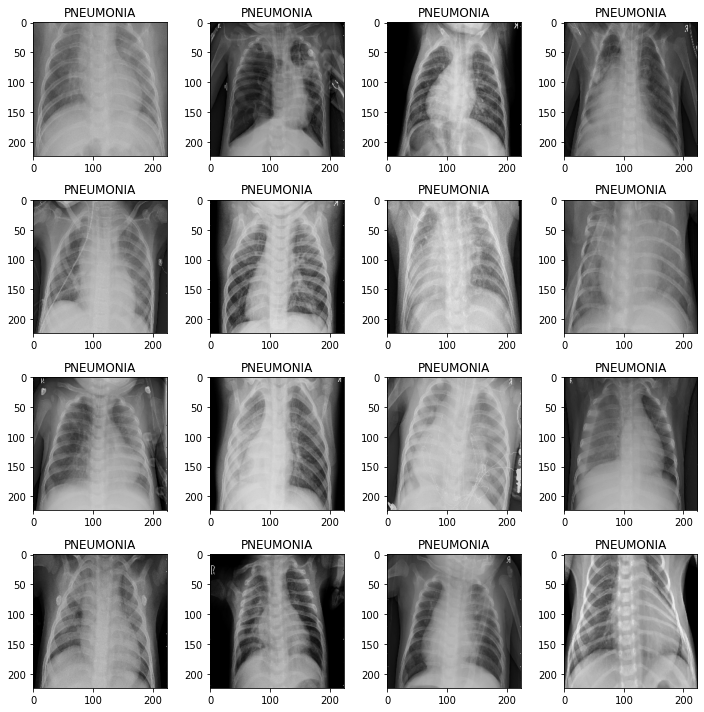

In [70]:
rows = 4
cols = 4
axes=[]
fig=plt.figure(figsize = (10,10))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a + 1) )
    axes[a].set_title(INV_LABELS[label[a].numpy()])  
    plt.imshow(image[a].numpy().reshape(224 , 224 , 3))
fig.tight_layout()    
plt.show()

In [71]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 24.8 ms, sys: 2.04 ms, total: 26.9 ms
Wall time: 26.6 ms
(32, 224, 224, 3)
(32,)


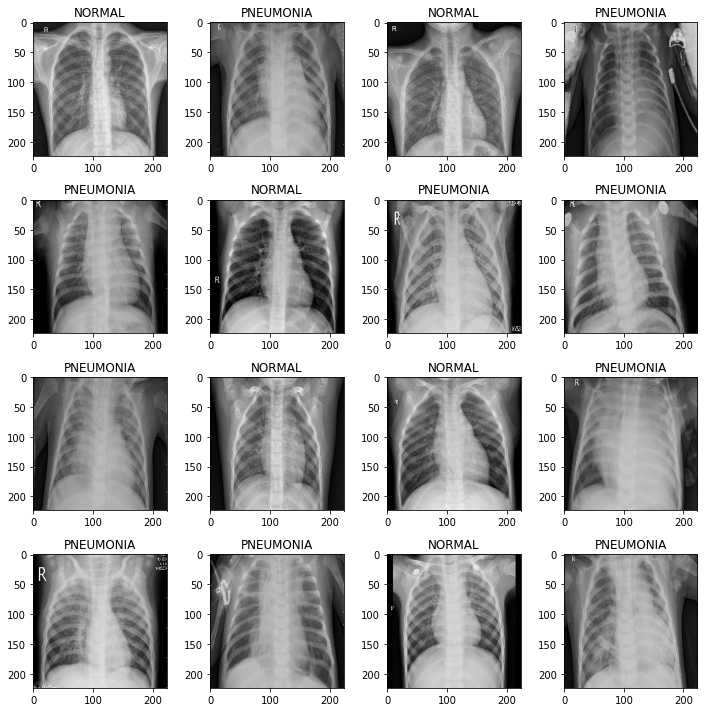

In [72]:
# View a sample Validation Image
rows = 4
cols = 4
axes=[]
fig=plt.figure(figsize = (10,10))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a + 1) )
    axes[a].set_title(INV_LABELS[label[a].numpy()])  
    plt.imshow(image[a].numpy().reshape(224 , 224 , 3))
fig.tight_layout()    
plt.show()

In [73]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [74]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [75]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [76]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9404 - precision: 0.9635 - recall: 0.9619
Epoch 00001: val_loss improved from inf to 31.70605, saving model to best_weights.h5
163/163 [==============================] - 167s 916ms/step - loss: 0.1640 - accuracy: 0.9404 - precision: 0.9635 - recall: 0.9619 - val_loss: 31.7060 - val_accuracy: 0.6546 - val_precision: 0.6557 - val_recall: 0.9975
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9632 - precision: 0.9791 - recall: 0.9716
Epoch 00002: val_loss improved from 31.70605 to 2.94805, saving model to best_weights.h5
163/163 [==============================] - 149s 917ms/step - loss: 0.0973 - accuracy: 0.9632 - precision: 0.9791 - recall: 0.9716 - val_loss: 2.9480 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9695 - precision: 0.9797 - recall: 0.

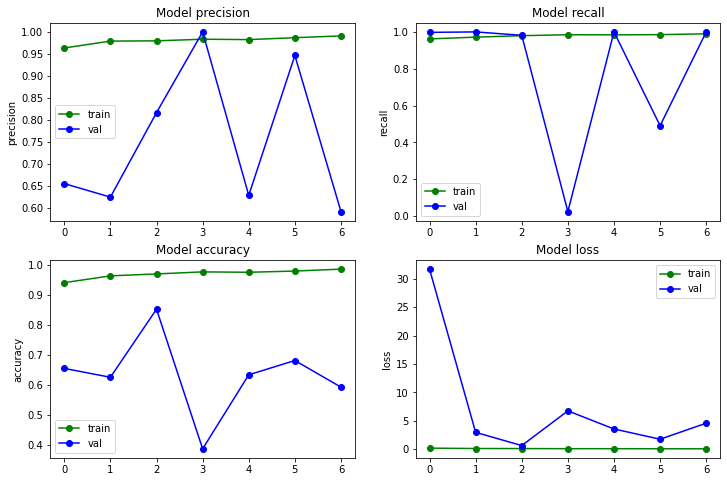

In [77]:
# Interpreting the Metrics 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

for index, metric in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[index].plot(history.history[metric], color = "green", marker = "o")
    ax[index].plot(history.history["val_" + metric], color = "blue", marker = "o")
    ax[index].set_title(f"Model {metric}")
    ax[index].set_ylabel(metric)
    ax[index].legend(["train", "val"])

In [93]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset

In [94]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [95]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


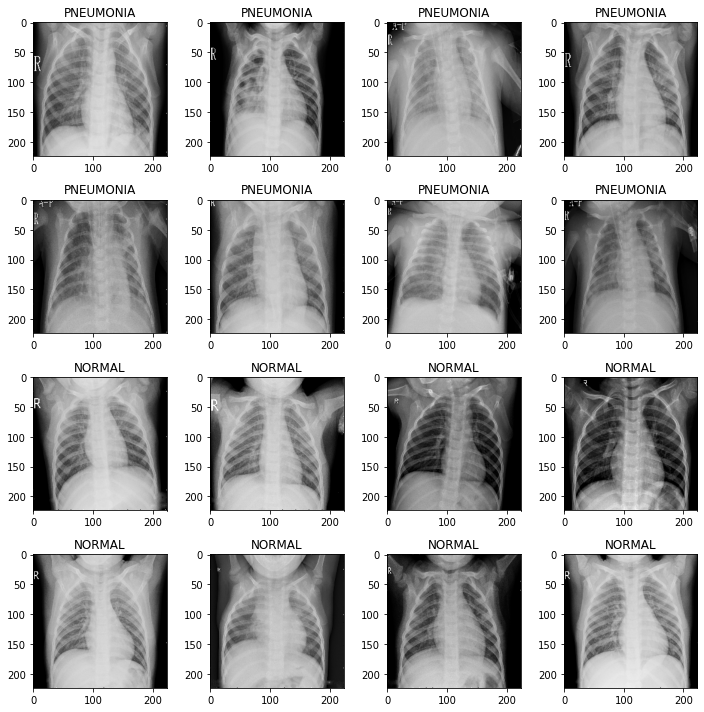

In [96]:
# View a sample Validation Image
rows = 4
cols = 4
axes=[]
fig=plt.figure(figsize = (10,10))

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a + 1) )
    axes[a].set_title(INV_LABELS[label[a].numpy()])  
    plt.imshow(image[a].numpy().reshape(224 , 224 , 3))
fig.tight_layout()    
plt.show()

In [98]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 1s 1s/step - loss: 0.6315 - accuracy: 0.8125 - precision: 0.7273 - recall: 1.0000
 Testing Acc :  0.8125
 Testing Precision  0.7272727489471436
 Testing Recall  1.0
